# Assignment-1, Aayush Verma, 06/16/2024

In [36]:
import calendar
import random
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow .keras.models import Sequential
from tensorflow.keras.layers import Embedding,GRU,LSTM,Bidirectional,TimeDistributed,Dense,Dropout,Activation,Input,RepeatVector,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.utils import split_dataset
import re
from matplotlib import pyplot as plt

## Question 1

### Generating Random dates using calendar and random modules

In [4]:
def generateDate():
    mi = random.choice(list(range(1,12+1)))
    m = list(calendar.month_name)[mi]
    y = random.choice(list(range(0,2024)))
    di = calendar.monthrange(y,mi)[1]
    mi = "0"*(2-len(str(mi)))+str(mi)
    d = random.choice(list(range(1,di+1)))
    d = "0"*(2-len(str(d)))+str(d)
    y = "0" * (4-len(str(y)))+str(y) 
    return (m+" "+str(d)+", "+y,y+"-"+str(mi)+"-"+str(d))

In [5]:
samples = [generateDate() for i in range(30000)]

In [6]:
samples[:5]

[('December 10, 1360', '1360-12-10'),
 ('April 12, 0233', '0233-04-12'),
 ('November 23, 1057', '1057-11-23'),
 ('August 04, 1261', '1261-08-04'),
 ('January 10, 1387', '1387-01-10')]

In [7]:
df = pd.DataFrame(samples,columns = ["x","y"])

### Visualizing created dates

In [8]:
df

,x,y
0,"December 10, 1360",1360-12-10
1,"April 12, 0233",0233-04-12
2,"November 23, 1057",1057-11-23
3,"August 04, 1261",1261-08-04
4,"January 10, 1387",1387-01-10
...,...,...
29995,"June 25, 0601",0601-06-25
29996,"September 01, 0556",0556-09-01
29997,"January 31, 0744",0744-01-31
29998,"January 13, 1943",1943-01-13


### All unique tokens in Corpus

In [9]:
''.join(sorted(set("".join(df['x'].map(lambda x :x.lower()).tolist())) | set("".join(df['y'].map(lambda x :x.lower()).tolist()))))

' ,-0123456789abcdefghijlmnoprstuvy'

### Adding the padding token '?' to the end of strings to make them the same length

In [10]:
df['x'] = df['x'].map(lambda x : x+(18-len(x))*"?")

In [11]:
df['y'] = df['y'].map(lambda x : x+(10-len(x))*"?")

### Creating tokenizers for X and for Y

In [13]:
xtokenizer = Tokenizer(char_level = True)
ytokenizer = Tokenizer(char_level = True)
xtokenizer.fit_on_texts(df['x'].tolist())
ytokenizer.fit_on_texts(df['y'].tolist())

### Encoding X and Y

In [14]:
xEncoded = xtokenizer.texts_to_sequences(df['x'].tolist())
yEncoded = ytokenizer.texts_to_sequences(df['y'].tolist())

In [15]:
xEncoded = np.array(xEncoded)
yEncoded = np.array(yEncoded)

### Creating Tensorflow Dataset for texts

In [16]:
dataset = tf.data.Dataset.from_tensor_slices((xEncoded,yEncoded))

### Train, Test and Validation split

In [17]:
train,test = split_dataset(dataset,left_size = 0.8)
train,val =  split_dataset(train,left_size = 0.85)

### Turning on Batching and Pre-Fetching to optimize performance

In [18]:
train = train.batch(32).prefetch(1)
val = val.batch(32).prefetch(1)
test = test.batch(32).prefetch(1)

### Sequence to Sequence Encoder-Decoder GRU Model

In [39]:
gru = Sequential(name = "gru")
gru.add(Input((18,)))
gru.add(Embedding(34,128,mask_zero = False))
gru.add(Bidirectional(GRU(32)))
gru.add(RepeatVector(10))
gru.add(Bidirectional(GRU(32,return_sequences = True)))
gru.add(TimeDistributed(Dense(13)))
gru.add(Activation("softmax"))
gru.summary()
gru.compile(optimizer = Adam(learning_rate = 0.0005),loss ="sparse_categorical_crossentropy",metrics = ["accuracy"])

Model: "gru"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 18, 128)           4352      
                                                                 
 bidirectional_7 (Bidirecti  (None, 64)                31104     
 onal)                                                           
                                                                 
 repeat_vector_3 (RepeatVec  (None, 10, 64)            0         
 tor)                                                            
                                                                 
 bidirectional_8 (Bidirecti  (None, 10, 64)            18816     
 onal)                                                           
                                                                 
 time_distributed_3 (TimeDi  (None, 10, 13)            845       
 stributed)                                                    

### Training the Model

In [40]:
logs = gru.fit(train,batch_size = 32,epochs = 60,validation_data = val,callbacks = [EarlyStopping(patience = 3,restore_best_weights=True)])

Epoch 1/60
638/638 [==============================] - 13s 11ms/step - loss: 1.5755 - accuracy: 0.4487 - val_loss: 1.0165 - val_accuracy: 0.6306
Epoch 2/60
638/638 [==============================] - 5s 8ms/step - loss: 0.8260 - accuracy: 0.6961 - val_loss: 0.6674 - val_accuracy: 0.7471
Epoch 3/60
638/638 [==============================] - 5s 8ms/step - loss: 0.5614 - accuracy: 0.7860 - val_loss: 0.4649 - val_accuracy: 0.8244
Epoch 4/60
638/638 [==============================] - 5s 8ms/step - loss: 0.3797 - accuracy: 0.8634 - val_loss: 0.3005 - val_accuracy: 0.8998
Epoch 5/60
638/638 [==============================] - 5s 9ms/step - loss: 0.2336 - accuracy: 0.9279 - val_loss: 0.1745 - val_accuracy: 0.9524
Epoch 6/60
638/638 [==============================] - 5s 9ms/step - loss: 0.1361 - accuracy: 0.9672 - val_loss: 0.1052 - val_accuracy: 0.9772
Epoch 7/60
638/638 [==============================] - 5s 8ms/step - loss: 0.0799 - accuracy: 0.9860 - val_loss: 0.0626 - val_accuracy: 0.9899
Epoc

### Evaluating Model

In [41]:
gru.evaluate(test)

188/188 [==============================] - 1s 4ms/step - loss: 2.8161e-05 - accuracy: 1.0000


[2.8160508009023033e-05, 1.0]

### Accuracy and Loss Curves

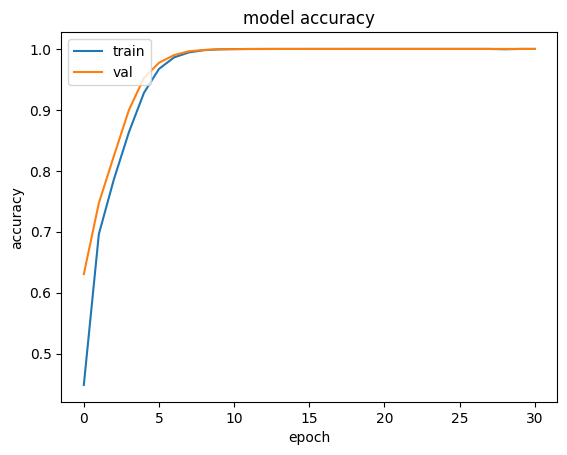

In [42]:
plt.plot(logs.history['accuracy'])
plt.plot(logs.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

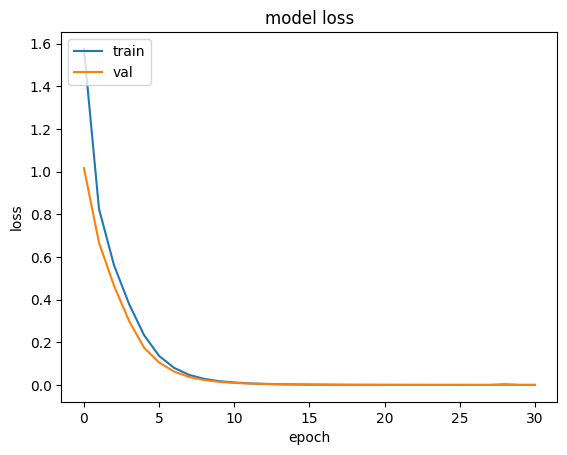

In [43]:
plt.plot(logs.history['loss'])
plt.plot(logs.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Looking at Real Outputs on One Batch

In [44]:
x = test.take(1)
preds = gru.predict(x)
x = xtokenizer.sequences_to_texts(list(x)[0][0].numpy())
x = list(map(lambda x: re.sub(r" |\?","",x),x))
preds = tf.math.argmax(preds,axis = 2)
preds = list(map(lambda x: re.sub(r" |\?","",x),ytokenizer.sequences_to_texts(preds.numpy())))
pd.DataFrame(zip(x,preds))

1/1 [==============================] - 1s 1s/step


,0,1
0,"april09,0695",0695-04-09
1,"april11,0529",0529-04-11
2,"july14,0721",0721-07-14
3,"september15,0618",0618-09-15
4,"february03,0250",0250-02-03
5,"september01,0157",0157-09-01
6,"january19,0807",0807-01-19
7,"april24,0156",0156-04-24
8,"september21,1413",1413-09-21
9,"may05,1946",1946-05-05


### Creating a function to convert any arbitrary date

In [50]:
def convertDate(date):
    date =  date+(18-len(date))*"?"
    date = [date]*32
    preds = gru.predict(xtokenizer.texts_to_sequences(date))
    preds = tf.math.argmax(preds,axis = 2)
    return list(map(lambda x: re.sub(r" |\?","",x),ytokenizer.sequences_to_texts(preds.numpy())))[0]

In [53]:
date  = "June 22, 2024"
convertDate(date)

1/1 [==============================] - 0s 47ms/step


'2024-06-22'